In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import os
from glob import glob
import time
from tqdm import tqdm
import torch
import pickle
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F

import nnModels as models
import nnExperiments as nnexp

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [1]:
# Perform single run for quick analysis
results = nnexp.runExperiment_measureIntegrationMNIST(useNet='CNN2P2',DEVICE=None,iterations=7,learningRate=5e-2)

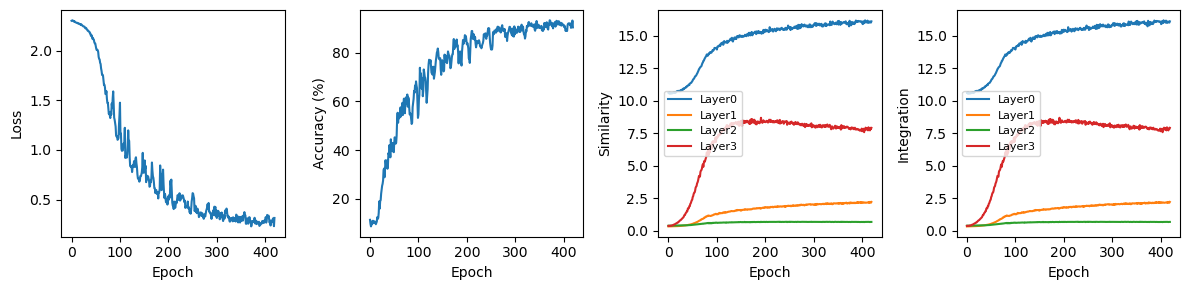

In [22]:
# This code plots absolute values of loss, accuracy, similarity, and integration
# -- useful for knowing what the true (unnormalized) values are --
numEpoch = results['trackLoss'].shape[0]
alignMean = models.CNN2P2.avgFromFull(results['alignFull'])
# Note: similarity and integration are only current -- I changed it to simMean,intMean,simStd,intStd for future reference and for plotting error bars!
fig,ax = plt.subplots(1,4,figsize=(12,3))
ax[0].plot(results['trackLoss'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(results['trackAccuracy'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
for i in range(alignMean.shape[0]):
    ax[2].plot(alignMean[i,:]*100,label=f'Layer{i}')
    ax[3].plot(alignMean[i,:]*100,label=f'Layer{i}')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Similarity')
ax[2].legend(prop={'size':8})
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Integration')
ax[3].legend(prop={'size':8})

plt.tight_layout()

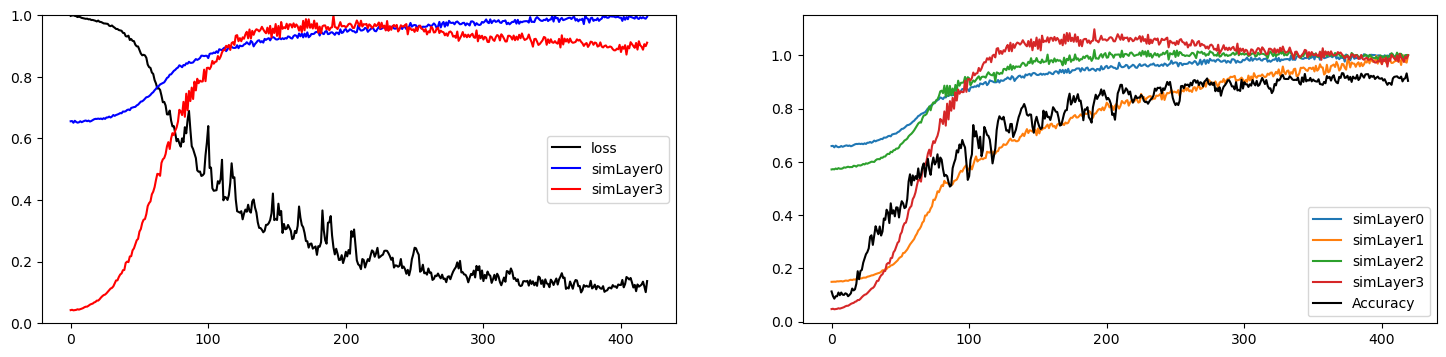

In [24]:
# This code plots relative loss & accuracy with similarity and integration to compare timescales of change
i1 = 0
i2 = 3
fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(range(numEpoch), results['trackLoss'] / torch.max(results['trackLoss']), c='k', label='loss')
ax[0].plot(range(numEpoch), alignMean[i1,:] / torch.max(alignMean[i1,:]), c='b', label=f'simLayer{i1}')
ax[0].plot(range(numEpoch), alignMean[i2,:] / torch.max(alignMean[i2,:]), c='r', label=f'simLayer{i2}')
ax[0].set_ylim(0,1)
ax[0].legend(loc='center right')
for i in range(alignMean.shape[0]):
    ax[1].plot(range(numEpoch),alignMean[i,:]/alignMean[i,-1], label=f'simLayer{i}')
ax[1].plot(range(numEpoch),results['trackAccuracy']/100, c='k', label='Accuracy')
ax[1].legend(loc='lower right')

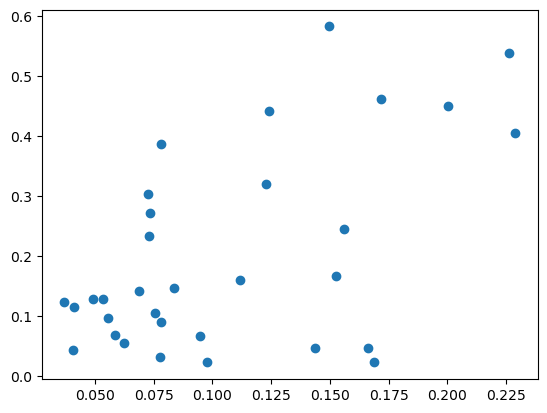

In [ ]:
# Compare similarity with change in weights for each layer
layer=0
sf = models.CNN2P2.layerFromFull(results['alignFull'],layer).detach().cpu()
dw = models.CNN2P2.layerFromFull(results['deltaWeights'],layer).detach().cpu()
plt.scatter(sf[:,0], dw[:,-1])

## Main Analysis Code Below
The first block performs multiple runs and saves the data. 
The second block loads the data and transforms it to useable arrays. 
The next group of blocks analyzes and plots the data. 

In [1]:
# Perform many runs
useNet = 'CNN2P2'
iterations = 100
learningRate = (8e-3, 5e-3, 2e-3)
numRuns = 5
numLR = len(learningRate)

runOffset = 6
doMultipleRuns = True
if doMultipleRuns:
    # Do Runs
    for runIdx in range(numRuns):
        for lr in tqdm(range(numLR)):
            print(f"Learning Rate: {lr+1}/{numLR}, Run: {runIdx+1}/{numRuns}...")
            results = nnexp.runExperiment_measureIntegrationMNIST(useNet=useNet,iterations=iterations,learningRate=learningRate[lr],verbose=False)

            # And Save
            saveDir=Path('data/integrationMNIST')
            fileName=f'integrationMNIST{runIdx+runOffset}_LR{lr}.pkl'
            with open(saveDir / fileName, 'wb') as f:
                pickle.dump(results, f)

In [4]:
# Analyze multiple runs 
saveDir=Path('data')
fileNames = glob("./data/integrationMNIST/*.pkl")
NF = len(fileNames)

nets = []
alignFull = []
deltaWeights = []
trackLoss = []
trackAccuracy = []
learningRate = []
for file in tqdm(fileNames):
    with open(file, 'rb') as f:
        results = pickle.load(f)
        nets.append(results['net'])
        alignFull.append(results['alignFull'])
        deltaWeights.append(results['deltaWeights'])
        trackLoss.append(results['trackLoss'])
        trackAccuracy.append(results['trackAccuracy'])
        learningRate.append(int(file[file.find('LR')+2:-4]))

# Also keep these (it's the same for each run)
trainloader = results['trainloader']
testloader = results['testloader']
learningRate = np.array(learningRate)
lrVals = np.unique(learningRate)

# Just for the reminder...
print(f"Keys available from results dictionary: {results.keys()}")

# Get better formatted summary statistics 
alignLayer0 = []
alignLayer1 = []
alignLayer2 = []
alignLayer3 = []
alignMean = []
dwLayer0 = []
dwLayer1= []
dwLayer2= []
dwLayer3= []
for sf,dw in zip(alignFull,deltaWeights):
    alignMean.append(models.CNN2P2.avgFromFull(sf))
    alignLayer0.append(models.CNN2P2.layerFromFull(sf,0))
    alignLayer1.append(models.CNN2P2.layerFromFull(sf,1))
    alignLayer2.append(models.CNN2P2.layerFromFull(sf,2))
    alignLayer3.append(models.CNN2P2.layerFromFull(sf,3))
    dwLayer0.append(models.CNN2P2.layerFromFull(dw,0))
    dwLayer1.append(models.CNN2P2.layerFromFull(dw,1))
    dwLayer2.append(models.CNN2P2.layerFromFull(dw,2))
    dwLayer3.append(models.CNN2P2.layerFromFull(dw,3))

# Do some helpful change to types and shapes
trackLoss = torch.stack(trackLoss)
trackAccuracy = torch.stack(trackAccuracy)
alignMean = torch.stack(alignMean)
alignLayer = [torch.stack(alignLayer0),torch.stack(alignLayer1),torch.stack(alignLayer2),torch.stack(alignLayer3)]
dwLayer = [torch.stack(dwLayer0),torch.stack(dwLayer1),torch.stack(dwLayer2),torch.stack(dwLayer3)]

# And for reminder, print shapes of them
print(f"TrackLoss.shape:{trackLoss.shape}, TrackAccuracy.shape:{trackAccuracy.shape}")
print(f"AlignMean.shape:{alignMean.shape}, len(AlignLayer):{len(alignLayer)}, alignLayer[0].shape:{alignLayer[0].shape}, len(dwLayer):{len(dwLayer)}, dwLayer[0].shape:{dwLayer[0].shape}")

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:50<00:00,  2.81s/it]


Keys available from results dictionary: dict_keys(['net', 'initWeights', 'alignFull', 'deltaWeights', 'trackLoss', 'trackAccuracy', 'trainset', 'testset', 'trainloader', 'testloader', 'learningRate'])
TrackLoss.shape:torch.Size([18, 6000]), TrackAccuracy.shape:torch.Size([18, 6000])
AlignMean.shape:torch.Size([18, 4, 6000]), len(AlignLayer):4, alignLayer[0].shape:torch.Size([18, 32, 6000]), len(dwLayer):4, dwLayer[0].shape:torch.Size([18, 32, 6000])


In [5]:
# Analyze test loss with targeted dropout experiment
dropoutFraction = 0.25
numLayers = len(alignLayer)-1
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...

numRuns = len(alignMean)
loss = torch.zeros((numRuns,numLayers))
lossNoHi = torch.zeros((numRuns,numLayers))
lossNoLo = torch.zeros((numRuns,numLayers))
lossRnd = torch.zeros((numRuns,numLayers))
accuracy = torch.zeros((numRuns,numLayers))
accuracyNoHi = torch.zeros((numRuns,numLayers))
accuracyNoLo = torch.zeros((numRuns,numLayers))
accuracyRnd = torch.zeros((numRuns,numLayers))
for runidx in tqdm(range(numRuns)):
    for layer in range(numLayers):
        num2look = int(dropoutFraction * alignLayer[layer].shape[1])
        idxFinalAlignment = torch.argsort(alignLayer[layer][runidx,:,-1])
        idxHi = idxFinalAlignment[-num2look:]
        idxLo = idxFinalAlignment[:num2look]
        
        # For each network / layer combination
        numAttempted = 0
        for batch in testloader:
            images,label = batch
            images = images.to(DEVICE)
            label = label.to(DEVICE)
            numAttempted += images.shape[0]
            
            # Get loss for no high
            outputs = models.CNN2P2.targetedDropout(nets[runidx], images, idxHi, layer)
            lossNoHi[runidx,layer] += loss_function(outputs,label).item()
            output1 = torch.argmax(outputs,axis=1)
            accuracyNoHi[runidx,layer] += sum(output1==label).cpu()
            # Get loss for no low
            outputs = models.CNN2P2.targetedDropout(nets[runidx], images, idxLo, layer)
            lossNoLo[runidx,layer] += loss_function(outputs,label).item()
            output1 = torch.argmax(outputs,axis=1)
            accuracyNoLo[runidx,layer] += sum(output1==label).cpu()
            
            # Get general loss
            outputs = nets[runidx](images)
            loss[runidx,layer] += loss_function(outputs,label).item()
            output1 = torch.argmax(outputs,axis=1)
            accuracy[runidx,layer] += sum(output1==label).cpu()
            # Get loss for random dropout
            idxRandom = torch.randperm(alignLayer[layer].shape[0])[:num2look]
            outputs = models.CNN2P2.targetedDropout(nets[runidx], images, idxRandom, layer)
            lossRnd[runidx,layer] += loss_function(outputs,label).item()
            output1 = torch.argmax(outputs,axis=1)
            accuracyRnd[runidx,layer] += sum(output1==label).cpu()
            
accuracy = 100*accuracy/numAttempted
accuracyNoHi = 100*accuracyNoHi/numAttempted
accuracyNoLo = 100*accuracyNoLo/numAttempted
accuracyRnd = 100*accuracyRnd/numAttempted

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:09<00:00,  3.86s/it]


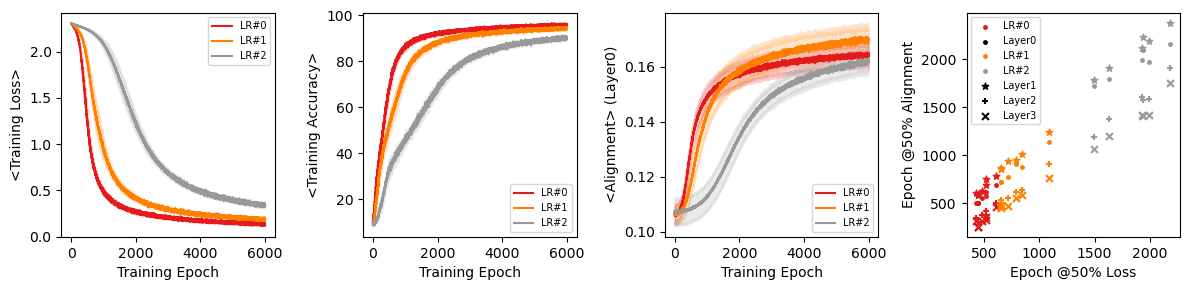

In [6]:
# Plot Analysis of Loss Trajectory and Similarity Trajectory 

# Create smoothing function
kernelSize = 10 # for smoothing trajectories
missingPoints = (kernelSize-1)
kernel = np.ones(kernelSize)/kernelSize
smooth = lambda x: np.convolve(x, kernel, mode='valid')

# Shapes and Size
NR,NT = trackLoss.shape
NL = len(alignLayer)
lrVals = np.unique(learningRate)
NLR = len(lrVals)

# Define colormap
cmap = cm.get_cmap('Set1', NLR).colors

# Make summary figure
showLayer = 0
fig,ax = plt.subplots(1,4,figsize=(12,3))

fontsize=7

# Plot loss trajectory
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]
    mnLoss = torch.mean(trackLoss[lridx],dim=0)
    seLoss = torch.std(trackLoss[lridx],dim=0)/np.sqrt(np.sum(lridx))
    ax[0].plot(range(NT), mnLoss, c=cmap[lr], label=f'LR#{lr}')
    ax[0].fill_between(range(NT), mnLoss+seLoss, mnLoss-seLoss, color=cmap[lr], alpha=0.2)
ax[0].set_xlabel('Training Epoch')
ax[0].set_ylabel('<Training Loss>')
ax[0].legend(fontsize=fontsize)

# Plot accuracy trajectory
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]
    mnAcc = torch.mean(trackAccuracy[lridx],dim=0)
    seAcc = torch.std(trackAccuracy[lridx],dim=0)/np.sqrt(np.sum(lridx))
    ax[1].plot(range(NT), mnAcc, c=cmap[lr], label=f'LR#{lr}')
    ax[1].fill_between(range(NT), mnAcc+seAcc, mnAcc-seAcc, color=cmap[lr], edgecolor=cmap[lr], alpha=0.2)
ax[1].set_xlabel('Training Epoch')
ax[1].set_ylabel('<Training Accuracy>')
ax[1].legend(fontsize=fontsize)

# Plot alignment trajectory for one layer
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]
    mnAlign = torch.mean(alignMean[lridx,showLayer],dim=0)
    seAlign = torch.std(alignMean[lridx,showLayer],dim=0)/np.sqrt(np.sum(lridx))
    ax[2].plot(range(NT), mnAlign, c=cmap[lr], label=f'LR#{lr}')
    ax[2].fill_between(range(NT), mnAlign+seAlign, mnAlign-seAlign, color=cmap[lr], edgecolor=cmap[lr], alpha=0.2)
ax[2].set_xlabel('Training Epoch')
ax[2].set_ylabel(f'<Alignment> (Layer{showLayer})')
ax[2].legend(fontsize=fontsize, loc='lower right')

# Compare 50% point for loss and alignment for one layer
mrkTypes=['.','*','+','x']
for slayer in range(NL):
    for lr in range(NLR):
        lridx = learningRate==lrVals[lr]
        loss50 = torch.zeros(np.sum(lridx))
        align50 = torch.zeros(np.sum(lridx))
        for idx,lossAlign in enumerate(zip(trackLoss[lridx],alignMean[lridx,slayer])):
            closs,calign = lossAlign
            loss50[idx] = torch.where(closs<=np.mean([closs.min(),closs.max()]))[0][0]
            align50[idx] = torch.where(calign>=np.mean([calign.min(),calign.max()]))[0][0]
        if slayer==0:
            ax[3].scatter(loss50[0],align50[0],color=cmap[lr],s=25,marker=mrkTypes[slayer],label=f'LR#{lr}')
        if lr==0:
            ax[3].scatter(loss50[0],align50[0],color='k',s=25,marker=mrkTypes[slayer],label=f'Layer{slayer}')
        ax[3].scatter(loss50,align50,color=cmap[lr],s=25,marker=mrkTypes[slayer])
ax[3].set_xlabel('Epoch @50% Loss')
ax[3].set_ylabel(f'Epoch @50% Alignment')
ax[3].legend(fontsize=fontsize)

plt.tight_layout()

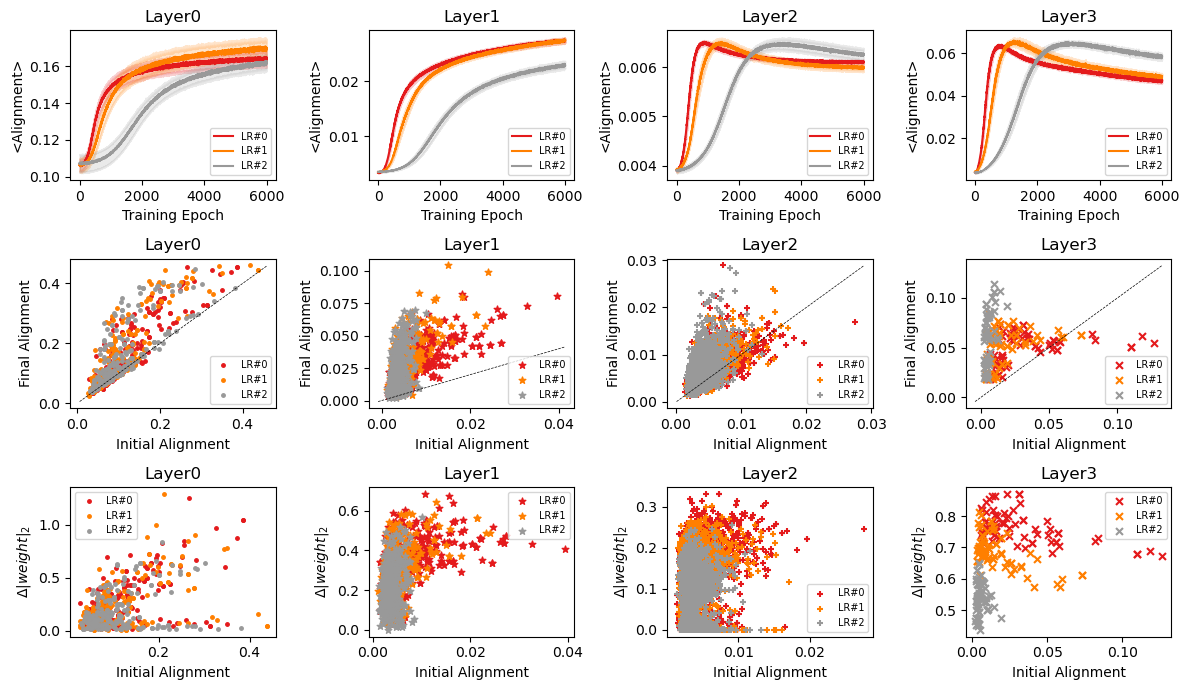

In [7]:
# Plot detailed analysis of node properties

# Make summary figure
showLayer = 0
fig,ax = plt.subplots(3,4,figsize=(12,7))

fontsize=7
alpha=1

avgFraction = 0.1
avgPoints = int(trackLoss.shape[1]*avgFraction)

# Compare initial and final alignment for each node
for slayer in range(NL):
    for lr in range(NLR):
        lridx = learningRate==lrVals[lr]
        mnAlign = torch.mean(alignMean[lridx,slayer],dim=0)
        seAlign = torch.std(alignMean[lridx,slayer],dim=0)/np.sqrt(np.sum(lridx))
        ax[0,slayer].plot(range(NT), mnAlign, c=cmap[lr], label=f'LR#{lr}')
        ax[0,slayer].fill_between(range(NT), mnAlign+seAlign, mnAlign-seAlign, color=cmap[lr], edgecolor=cmap[lr], alpha=0.2)
    ax[0,slayer].set_xlabel('Training Epoch')
    ax[0,slayer].set_ylabel(f'<Alignment>')
    ax[0,slayer].set_title(f'Layer{slayer}')
    ax[0,slayer].legend(fontsize=fontsize, loc='best')
    
# Compare initial and final alignment for each node
for slayer in range(NL):
    for lr in range(NLR):
        lridx = learningRate==lrVals[lr]
        cinit = torch.mean(alignLayer[slayer][lridx,:,:avgPoints],dim=2)
        cfinal = torch.mean(alignLayer[slayer][lridx,:,-avgPoints:],dim=2)
        ax[1,slayer].scatter(cinit[0], cfinal[0], color=cmap[lr], s=25,marker=mrkTypes[slayer], alpha=alpha, label=f'LR#{lr}')
        ax[1,slayer].scatter(cinit, cfinal, color=cmap[lr], s=25,marker=mrkTypes[slayer], alpha=alpha)
    xLim=ax[1,slayer].get_xlim()
    ax[1,slayer].plot(xLim,xLim,c='k',linewidth=0.5,linestyle='--')
    ax[1,slayer].set_xlabel('Initial Alignment')
    ax[1,slayer].set_ylabel('Final Alignment')
    ax[1,slayer].set_title(f'Layer{slayer}')
    ax[1,slayer].legend(fontsize=fontsize,loc='lower right')

# Compare initial alignment and norm change in weight for each node
avgUntil = 0.1
avgPoints = int(NT*avgUntil)
dwAvg = 0.1
dwPoints = int(NT*dwAvg)
for slayer in range(NL):
    for lr in range(NLR):
        lridx = learningRate==lrVals[lr]
        cAlign = torch.mean(alignLayer[slayer][lridx,:,:avgPoints],dim=2)
        cChange = torch.mean(dwLayer[slayer][lridx,:,-dwPoints:],dim=2)
        ax[2,slayer].scatter(cAlign[0], cChange[0], color=cmap[lr], s=25,marker=mrkTypes[slayer], alpha=alpha, label=f'LR#{lr}')
        ax[2,slayer].scatter(cAlign, cChange, color=cmap[lr], s=25,marker=mrkTypes[slayer], alpha=alpha)
    ax[2,slayer].set_xlabel('Initial Alignment')
    ax[2,slayer].set_ylabel('$\u0394|weight|_2$')
    ax[2,slayer].set_title(f'Layer{slayer}')
    ax[2,slayer].legend(fontsize=fontsize,loc='best')

plt.tight_layout()

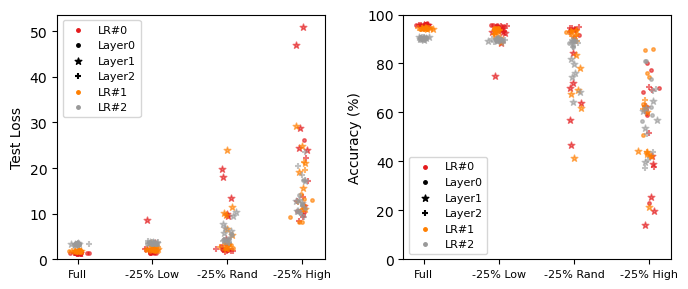

In [8]:
# Plot Results of Targeted Dropout Experiment
mkrSize = 25
rndSpread = 0.05
alpha = 0.6
fontsize=8

fig,ax = plt.subplots(1,2,figsize=(7,3))
for lr in range(NLR):
    lridx = learningRate==lrVals[lr]    
    for slayer in range(NL-1):
        if slayer==0:
            ax[0].scatter(0, -1*loss[np.where(lridx)[0][0],slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'LR#{lr}')
            ax[1].scatter(0, -1*accuracy[np.where(lridx)[0][0],slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'LR#{lr}')
        if lr==0:
            ax[0].scatter(0, -1*loss[np.where(lridx)[0][0],slayer], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'Layer{slayer}')
            ax[1].scatter(0, -1*accuracy[np.where(lridx)[0][0],slayer], color='k', s=mkrSize, marker=mrkTypes[slayer], alpha=1, label=f'Layer{slayer}')
        ax[0].scatter(torch.normal(0,rndSpread,(np.sum(lridx),1)), loss[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[0].scatter(torch.normal(1,rndSpread,(np.sum(lridx),1)), lossNoLo[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[0].scatter(torch.normal(2,rndSpread,(np.sum(lridx),1)), lossRnd[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[0].scatter(torch.normal(3,rndSpread,(np.sum(lridx),1)), lossNoHi[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)

        ax[1].scatter(torch.normal(0,rndSpread,(np.sum(lridx),1)), accuracy[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[1].scatter(torch.normal(1,rndSpread,(np.sum(lridx),1)), accuracyNoLo[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[1].scatter(torch.normal(2,rndSpread,(np.sum(lridx),1)), accuracyRnd[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
        ax[1].scatter(torch.normal(3,rndSpread,(np.sum(lridx),1)), accuracyNoHi[lridx,slayer], color=cmap[lr], s=mkrSize, marker=mrkTypes[slayer], alpha=alpha)
xTickLabel=['Full','-25% Low','-25% Rand','-25% High']
ax[0].set_xticks([0,1,2,3],labels=xTickLabel,fontsize=fontsize)
ax[1].set_xticks([0,1,2,3],labels=xTickLabel,fontsize=fontsize)
ax[0].set_ylim(0,None)
ax[1].set_ylim(0,100)
ax[0].set_ylabel('Test Loss')
ax[1].set_ylabel('Accuracy (%)')
ax[0].legend(fontsize=fontsize,loc='best')
ax[1].legend(fontsize=fontsize,loc='best')

plt.tight_layout();

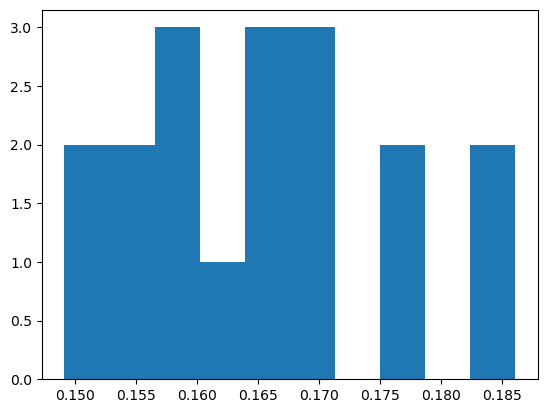

In [13]:
# Measure eigenvalues of inputs to compare with alignment
plt.hist(alignMean[:,0,-1].numpy());

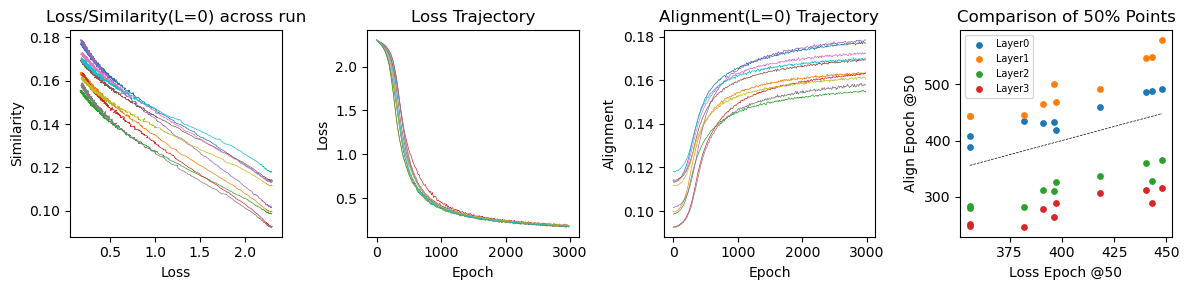

In [63]:
# Plot Analysis of Loss Trajectory and Similarity Trajectory 

# Create smoothing function
kernelSize = 10 # for smoothing trajectories
missingPoints = (kernelSize-1)
kernel = np.ones(kernelSize)/kernelSize
smooth = lambda x: np.convolve(x, kernel, mode='valid')

# Define colormap
cmap = cm.get_cmap('Set1', NLR).colors

# Shapes and Size
NR = len(trackLoss)
NT = trackLoss[0].shape[0]
NL = len(alignMean[0])
NLR = len(np.unique(learningRate))

# Plot trajectory of loss over similarity
showLayer = 0
numFiles = len(simMean)
fig,ax = plt.subplots(1,4,figsize=(12,3))

for ss,tl in zip(alignMean, trackLoss):
    ax[0].plot(smooth(tl), smooth(ss[showLayer,:]), linewidth=0.5, alpha=1)
ax[0].set_xlabel('Loss')
ax[0].set_ylabel('Similarity')
ax[0].set_title('Loss/Similarity(L=0) across run')

# Get times to 50% of the curves
showLayer = 0
loss50 = missingPoints*torch.ones(NR)
align50 = missingPoints*torch.ones((NL,NR))
for idx,sstl in enumerate(zip(alignMean, trackLoss)):
    ss,tl = sstl
    tl = torch.tensor(smooth(tl))
    # loss50[idx] += torch.argmin(torch.abs(tl - np.mean([tl.min(),tl.max()])))
    loss50[idx] += torch.where(tl<=np.mean([tl.min(),tl.max()]))[0][0]
    ax[1].plot(range(NT-2*missingPoints), smooth(tl), linewidth=0.5)
    ssLayer = torch.tensor(smooth(ss[showLayer,:]))
    ax[2].plot(range(NT-2*missingPoints), smooth(ssLayer), linewidth=0.5)
    for layer in range(NL):
        ssLayer = torch.tensor(smooth(ss[layer,:]))
        # sim50[layer,idx] += torch.argmin(torch.abs(ssLayer - np.mean([ssLayer.min(),ssLayer.max()])))
        align50[layer,idx] += torch.where(ssLayer>=np.mean([ssLayer.min(),ssLayer.max()]))[0][0]
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss Trajectory')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Alignment')
ax[2].set_title(f'Alignment(L={showLayer}) Trajectory')

# And scatter times for each layer
for layer in range(NL):
    ax[3].scatter(loss50, align50[layer,:], label=f"Layer{layer}",s=15)
ax[3].plot([np.min(loss50.numpy()),np.max(loss50.numpy())],[np.min(loss50.numpy()),np.max(loss50.numpy())],c='k',linewidth=0.5,linestyle='--')
ax[3].set_xlabel('Loss Epoch @50')
ax[3].set_ylabel('Align Epoch @50')
ax[3].legend(fontsize=7)
ax[3].set_title('Comparison of 50% Points')

plt.tight_layout()

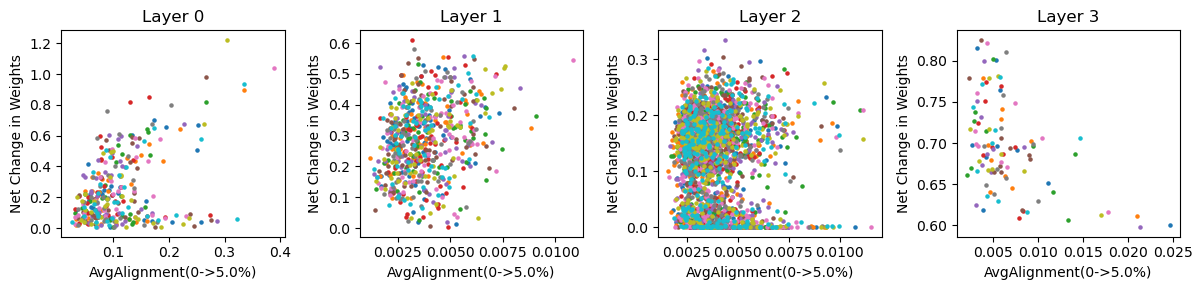

In [179]:
# Now, compare similarity with change in weights for each layer
avgUntil = 0.05
avgPoints = int(alignLayer0[0].shape[1]*avgUntil)
netSim = lambda sim: torch.mean(sim[:,:avgPoints],dim=1)
dwAvg = 0.01
dwPoints = int(dwLayer0[0].shape[1]*avgUntil)
netDW = lambda dw: torch.mean(dw[:,-dwPoints:],dim=1)

fig,ax = plt.subplots(1,4,figsize=(12,3))
for sim,dw in zip(alignLayer0,dwLayer0):
    ax[0].scatter(netSim(sim),netDW(dw),s=5)
ax[0].set_xlabel(f'AvgAlignment(0->{avgUntil*100}%)')
ax[0].set_ylabel('Net Change in Weights')
ax[0].set_title('Layer 0')

for sim,dw in zip(alignLayer1,dwLayer1):
    ax[1].scatter(netSim(sim),netDW(dw),s=5)
ax[1].set_xlabel(f'AvgAlignment(0->{avgUntil*100}%)')
ax[1].set_ylabel('Net Change in Weights')
ax[1].set_title('Layer 1')

for sim,dw in zip(alignLayer2,dwLayer2):
    ax[2].scatter(netSim(sim),netDW(dw),s=5)
ax[2].set_xlabel(f'AvgAlignment(0->{avgUntil*100}%)')
ax[2].set_ylabel('Net Change in Weights')
ax[2].set_title('Layer 2')

for sim,dw in zip(alignLayer3,dwLayer3):
    ax[3].scatter(netSim(sim),netDW(dw),s=5)
ax[3].set_xlabel(f'AvgAlignment(0->{avgUntil*100}%)')
ax[3].set_ylabel('Net Change in Weights')
ax[3].set_title('Layer 3')

plt.tight_layout()